### 目的
- 为了使用 GPytorch 来替代 sklearn.gaussian_process

In [81]:
import torch
import gpytorch
import numpy as np
from gaussian_process import GaussianProcessWrapper
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

pybullet build time: Nov 28 2023 23:45:17


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
observed_point = [[0,0.1,0.0],[0,0.2,0.1],[0,0.3,0.2],[0,0.4,0.3]]
def show_heatmap(data):
    plt.imshow(data.reshape((40,40)),cmap='viridis',aspect='equal')

In [83]:
gp_sklearn = GaussianProcessWrapper(6,[1,2,3,4,5],None,0)
for point in observed_point:
    for gp in gp_sklearn.GPs:
        gp.add_observed_point(np.array(point).reshape((-1,3)),np.array(1.0))

In [84]:
%%time
gp_sklearn.update_GPs()
all_pred,_,_ = gp_sklearn.update_grids(1)

RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([4, 1]), while the reported shape of the mean is torch.Size([4]).

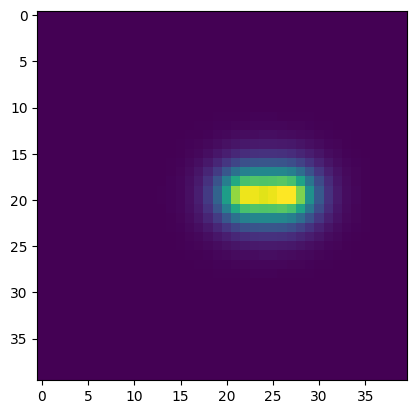

In [85]:
show_heatmap(all_pred)

### 
这里使用一个 gpytoch 版本实现的 gp

In [86]:
import gpytorch.constraints


class GaussianProcessTorch(gpytorch.models.ExactGP):
    
    def __init__(self, train_inputs, train_targets):
        likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
        super().__init__(train_inputs, train_targets, likelihood)
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5,ard_num_dims=3)) # x,y,time

        # 固定核参数
        self.covar_module.base_kernel.raw_lengthscale = torch.nn.Parameter(torch.tensor([0.1,0.1,3]),requires_grad=False)
        for param in self.covar_module.base_kernel.parameters():
            param.requires_grad = False
        self.covar_module.base_kernel.register_constraint("raw_lengthscale",gpytorch.constraints.Interval(0.1,3,transform=None,inv_transform=None))
        # 设置 dtype
        torch.set_default_dtype(torch.float64)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
    def fit(self,train_x,train_y,verbose=False):
        self.train()
        self.likelihood.train()
        optimizer = torch.optim.Adam(self.parameters(),lr=0.1)
        # loss of gp
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood,self)
        train_iter = 1

        for i in range(train_iter):
            optimizer.zero_grad()
            ouput = self(train_x)
            loss = -mll(ouput,train_y)
            loss.backward()
            optimizer.step()
    
    def predict(self,x):
        '''
        Args
            x: 为带有 t 的 heatmap
        '''
        self.eval()
        self.likelihood.eval()
        with torch.no_grad() , gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self(x))
        return observed_pred

In [120]:
device = "cuda"
train_x = torch.from_numpy(np.array(observed_point)).to(device)
train_y = torch.ones(4).to(device)
zero_x = torch.zeros(1,3).to(device)
zero_y = torch.ones(1).to(device)
gp_torch = GaussianProcessTorch(train_x,train_y).to(device)

In [121]:
gp_torch.covar_module.base_kernel.lengthscale
print(gp_torch.train_inputs)

(tensor([[0.0000, 0.1000, 0.0000],
        [0.0000, 0.2000, 0.1000],
        [0.0000, 0.3000, 0.2000],
        [0.0000, 0.4000, 0.3000]], device='cuda:0'),)


In [122]:
gp_torch.train_inputs = [train_x]
gp_torch.train_targets = train_y

In [123]:
gp_torch.covar_module.base_kernel.lengthscale

Parameter containing:
tensor([0.1000, 0.1000, 3.0000], device='cuda:0')

In [124]:
def add_t(X, t: float):
    return np.concatenate((X, np.zeros((X.shape[0], 1)) + t), axis=1)

In [128]:
from itertools import product
grid = np.array(list(product(
                    np.linspace(-1, 1, 40),
                    np.linspace(-1, 1, 40),)))  # in shape (self.grid_size **2 , 2)

# get into eval mode

pred = gp_torch.predict(torch.from_numpy(add_t(grid,1.0)).to(device))
# gp_torch( torch.from_numpy(add_t(grid,1.0)).to(device) )

In [129]:
pred.mean.cpu().detach().numpy().shape

(1600,)

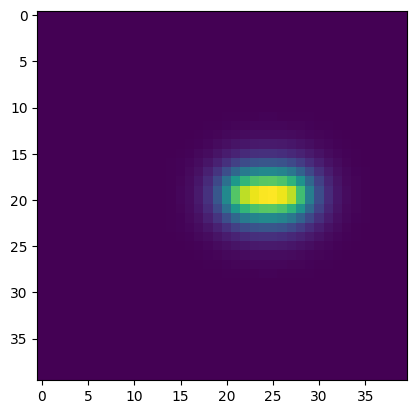

In [130]:
show_heatmap( pred.mean.cpu().detach().numpy() )